* Regresia logistică este un model liniar generalizat (GLM) utilizat pentru problemele de clasificare binară, adică pentru a prezice probabilitatea unei instanțe de a aparține uneia dintre cele două clase 

in cazul urmator, admis sau nu

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

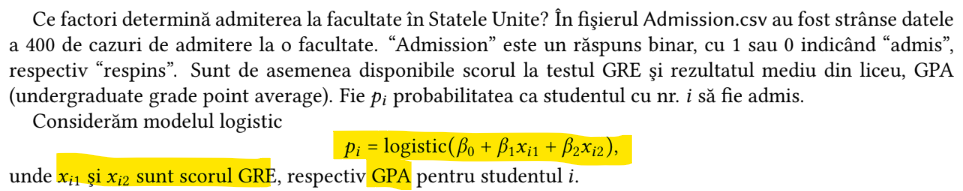

In [59]:
admissions = pd.read_csv("Admission.csv")

y = admissions["Admission"]
print(len(y[y==1]),len(y[y==0])) #date nebalansate
Index = np.random.choice(np.flatnonzero(y==0), size=len(y[y==0])-len(y[y==1]), replace=False) #pentru a balansa datele, alegem la intamplare indici pentru a fi stersi
admissions = admissions.drop(labels=Index)
y = admissions["Admission"]
x_GRE = admissions["GRE"].values
x_GPA = admissions["GPA"].values
x_GRE_mean = x_GRE.mean()
x_GRE_std = x_GRE.std()
x_GPA_mean = x_GPA.mean()
x_GPA_std = x_GPA.std()

#standardizam datele:
# adica, variabilele sunt ajustate astfel încât să aibă o medie zero și o deviație standard de unu. 
# => variabilele sunt aduse la aceeași scară și pentru a facilita comparațiile între ele în cadrul unui model sau analiză statistică.
x_GRE = (x_GRE-x_GRE_mean)/x_GRE_std
x_GPA = (x_GPA-x_GPA_mean)/x_GPA_std
X = np.column_stack((x_GRE,x_GPA))

127 273


**1.**

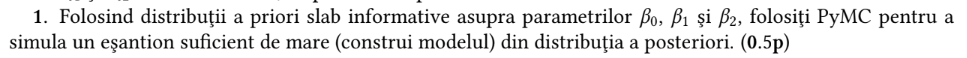

   - constr modelului logistic

In [60]:
with pm.Model() as adm_model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1, shape = 2)
    X_shared = pm.MutableData('x_shared',X) #pentru pct. 3 si 4
    mu = pm.Deterministic('μ',alpha + pm.math.dot(X_shared, beta))
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    bd = pm.Deterministic("bd", -alpha/beta[1] - beta[0]/beta[1] * x_GRE)
    y_pred = pm.Bernoulli("y_pred", p=theta, observed=y)
    idata = pm.sample(2000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


**2.** 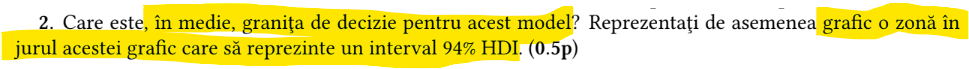

Text(0, 0.5, 'GPA')

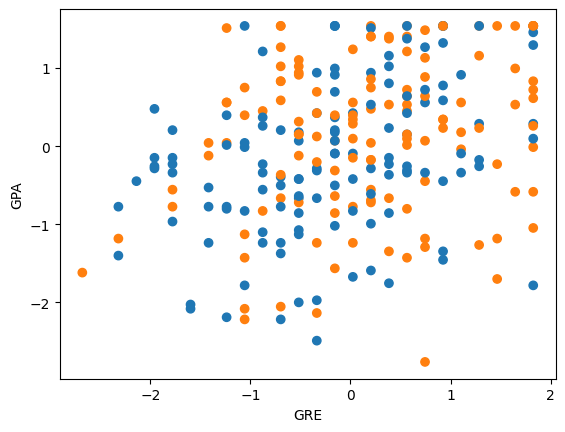

In [61]:
idx = np.argsort(x_GRE)
bd = idata.posterior["bd"].mean(("chain", "draw"))[idx]
plt.scatter(x_GRE, x_GPA, c=[f"C{x}" for x in y])
plt.xlabel("GRE")
plt.ylabel("GPA")

Text(0, 0.5, 'GPA')

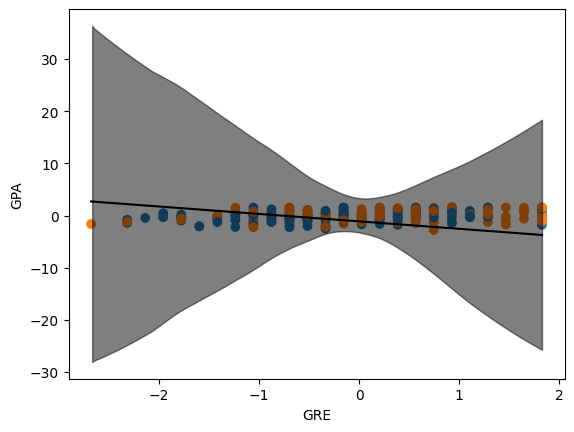

In [62]:
idx = np.argsort(x_GRE)
bd = idata.posterior["bd"].mean(("chain", "draw"))[idx]
plt.scatter(x_GRE, x_GPA, c=[f"C{x}" for x in y])
plt.plot(x_GRE[idx], bd, color = 'k')
az.plot_hdi(x_GRE, idata.posterior["bd"], color ='k')
plt.xlabel("GRE")
plt.ylabel("GPA")

**3.**
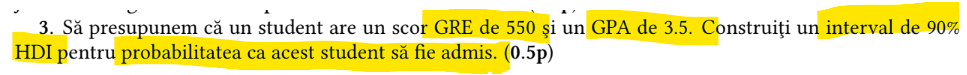 


**Var. 1.**

<Axes: title={'center': 'x'}>

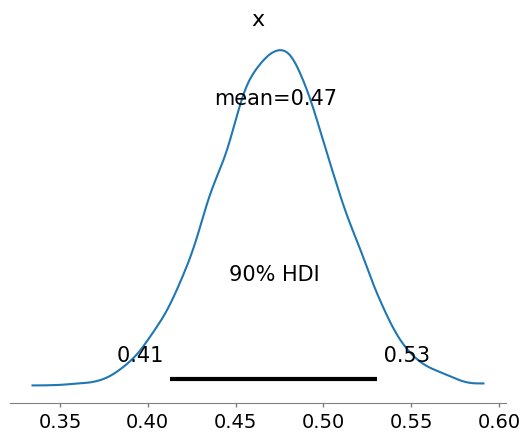

In [96]:
obs_std1 = [(550-x_GRE_mean)/x_GRE_std,(3.5-x_GPA_mean)/x_GPA_std]
sigmoid = lambda x: 1 / (1 + np.exp(-x))
posterior_g = idata.posterior.stack(samples={"chain", "draw"})
mu = posterior_g['alpha'] + posterior_g['beta'][0]*obs_std1[0] + posterior_g['beta'][1]*obs_std1[1]
theta = sigmoid(mu)
az.plot_posterior(theta.values, hdi_prob=0.9)

**Var. 2.**

Sampling: []


<Axes: title={'center': 'x'}>

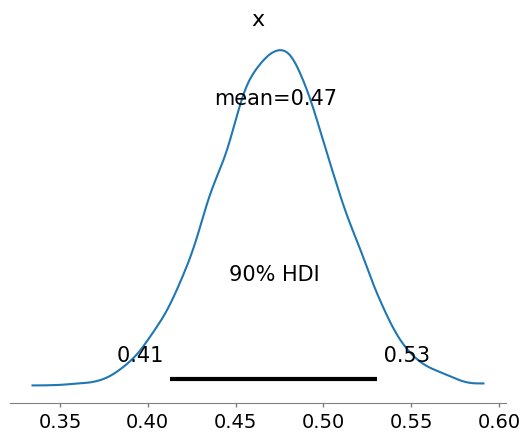

In [92]:
pm.set_data({"x_shared":[obs_std1]}, model=adm_model)
ppc = pm.sample_posterior_predictive(idata, model=adm_model,var_names=["theta"])
y_ppc = ppc.posterior_predictive['theta'].stack(sample=("chain", "draw")).values
az.plot_posterior(y_ppc,hdi_prob=0.9)

**4.** 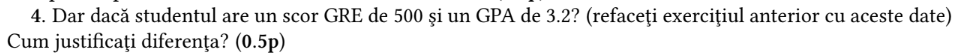

Sampling: []


<Axes: title={'center': 'x'}>

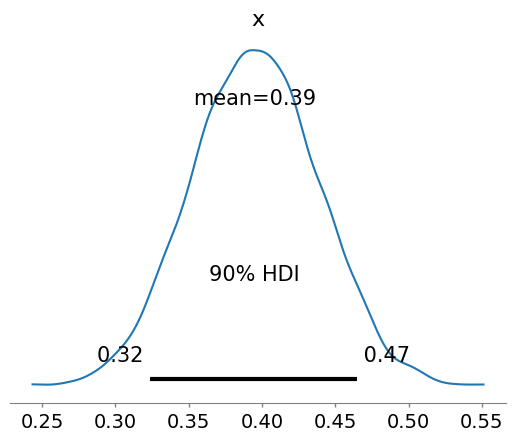

In [70]:
obs_std2 = [(500-x_GRE_mean)/x_GRE_std,(3.2-x_GPA_mean)/x_GPA_std]
pm.set_data({"x_shared":[obs_std2]}, model=adm_model)
ppc = pm.sample_posterior_predictive(idata, model=adm_model,var_names=["theta"])
y_ppc = ppc.posterior_predictive['theta'].stack(sample=("chain", "draw")).values
az.plot_posterior(y_ppc,hdi_prob=0.9)

In [71]:
print(obs_std1)
print(obs_std2)

[-0.4265605149409403, 0.17756928382132015]
[-0.8772525731564094, -0.6385212497140564]


Observăm că punctul obs_std1 este mai apropiat de frontiera de decizie față de obs_std2, ceea ce explică gradul mai mic de incertitudine (39% față de 47% în medie) pentru apartenența la o clasă a acestuia din urmă.

Text(0, 0.5, 'GPA')

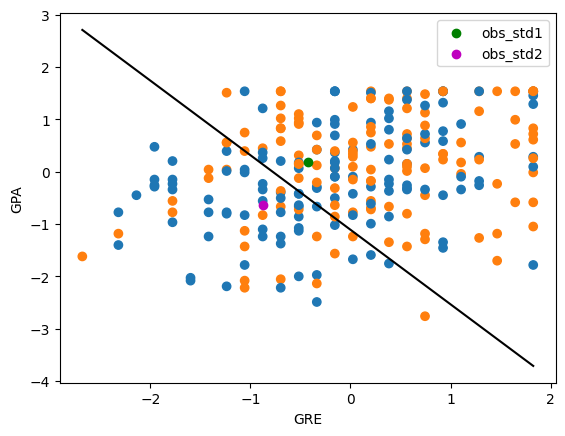

In [76]:
idx = np.argsort(x_GRE)
bd = idata.posterior["bd"].mean(("chain", "draw"))[idx]
plt.scatter(x_GRE, x_GPA, c=[f"C{x}" for x in y])
plt.plot(x_GRE[idx], bd, color = 'k')
plt.scatter(obs_std1[0], obs_std1[1], color = 'g', label= 'obs_std1')
plt.scatter(obs_std2[0], obs_std2[1], color = 'm', label= 'obs_std2')
plt.legend()
#az.plot_hdi(x_GRE, idata.posterior["bd"], color ='k')
plt.xlabel("GRE")
plt.ylabel("GPA")